In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
import argparse
import numpy as np
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import os
import json
from functools import partial
import sys
from tqdm import tqdm


from tianshou.utils import WandbLogger
from tianshou.data import Batch, Collector, ReplayBuffer, VectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.policy import BasePolicy, PPOPolicy
from tianshou.trainer import OnpolicyTrainer
from tianshou.utils.net.common import ActorCritic, Net
#from tianshou.utils.net.discrete import Actor, Critic
from tianshou.utils.net.continuous import Actor, Critic, ActorProb

import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import TimeLimit, RescaleAction, TransformObservation
from stable_baselines3.common.env_checker import check_env

from lib.environments import get_environment
from lib.environments.kolmogorov import KolmogorovEnvironment
from lib.policy import get_rl_algo
from lib.distributions import ElementwiseNormal
from lib.models import get_actor_critic
from lib.utils import str2bool, Config, dict_to_wandb_table, restrict_to_num_threads
from lib.trainer import MyOnpolicyTrainer

#temporary solution for xlb imports
sys.path.append(os.path.abspath('/home/pfischer/XLB'))
#from my_flows.kolmogorov_2d import Kolmogorov_flow
from my_flows.helpers import get_kwargs

import wandb
wandb.require("core")

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def get_args() -> argparse.Namespace:
    parser = argparse.ArgumentParser()
    parser.add_argument("--task", type=str, default="CartPole-v1")
    parser.add_argument("--model", type=str, default="ppo")
    parser.add_argument("--reward_threshold", type=int, default=500)
    parser.add_argument("--seed", type=int, default=42)
    parser.add_argument("--buffer_size", type=int, default=5000)
    parser.add_argument("--max_epoch", type=int, default=5)
    parser.add_argument("--step_per_epoch", type=int, default=100)
    parser.add_argument("--train_num", type=int, default=1)
    parser.add_argument("--test_num", type=int, default=1)
    parser.add_argument("--logdir", type=str, default="log")
    parser.add_argument("--gamma", type=float, default=0.97)
    parser.add_argument("--lr", help='learning rate', type=float, default=0.0003)
    parser.add_argument("--repeat_per_collect", type=int, default=1)
    parser.add_argument("--episode_per_test", type=int, default=1)
    parser.add_argument("--batch_size", type=int, default=32)
    parser.add_argument("--step_per_collect", type=int, default=10) 
    parser.add_argument("--architecture", type=int, default=[64, 64])

    return parser.parse_known_args()[0]


def create_env(kwargs1, kwargs2):
    """
    creates the environemnt and applyes wrappers to action and
    observations space and sets time limit.
    """
    env = KolmogorovEnvironment(kwargs1, kwargs2)
    env = TimeLimit(env, max_episode_steps=200)
    env = RescaleAction(env, min_action=-1., max_action=1.)
    env = TransformObservation(env, lambda obs: (obs/20))
    return env

In [4]:
#######################################################################################################
####### setup stuff *##################################################################################
#######################################################################################################
args = get_args()
# seed
np.random.seed(args.seed)
torch.manual_seed(args.seed)

#restrict_to_num_threads(1)

In [5]:
#######################################################################################################
####### environments ##################################################################################
#######################################################################################################
u0_path = "/home/pfischer/XLB/vel_init/velocity_burn_in_1806594.npy" #4096x4096 simulation
rho0_path = "/home/pfischer/XLB/vel_init/density_burn_in_1806594.npy" #4096x4096 simulation
kwargs1, _,_,_ = get_kwargs(u0_path=u0_path, rho0_path=rho0_path, lamb=1) #cgs 
kwargs2, _,_,_ = get_kwargs(u0_path=u0_path, rho0_path=rho0_path, lamb=1) #fgs
env = create_env(kwargs1, kwargs2)
train_env = DummyVectorEnv([lambda: create_env(kwargs1, kwargs2) for _ in range(args.train_num)])
test_env = DummyVectorEnv([lambda: create_env(kwargs1, kwargs2) for _ in range(args.test_num)])
#train_env = DummyVectorEnv([create_env(kwargs1, kwargs2)])
#test_env = DummyVectorEnv([create_env(kwargs1, kwargs2)])

m_prime = 31232.0, end time = 31232 steps, T=355, io_rate = 64.0, Number of outputs = 490.0


m_prime = 31232.0, end time = 31232 steps, T=355, io_rate = 64.0, Number of outputs = 490.0


In [6]:
print(env.observation_space.shape)
print(env.action_space.shape)

(128, 128)
(1,)


In [7]:
#Policy
assert env.observation_space.shape is not None  # for mypy
assert env.action_space.shape is not None

net = Net(state_shape=env.observation_space.shape, hidden_sizes=args.architecture, device=device).to(device)
actor = ActorProb(preprocess_net=net, action_shape=env.action_space.shape, max_action=1, device=device).to(device)
critic = Critic(preprocess_net=net, device=device).to(device)
actor_critic = ActorCritic(actor=actor, critic=critic)
optim = torch.optim.Adam(actor_critic.parameters(), lr=args.lr)
dist = torch.distributions.Normal
policy = PPOPolicy(
    actor=actor,
    critic=critic,
    optim=optim,
    dist_fn=dist,
    action_space=env.action_space,
    deterministic_eval=True,
    action_scaling=False,
)

In [8]:
#Collectors
train_collector = Collector(
    policy=policy,
    env=train_env,
    buffer=VectorReplayBuffer(args.buffer_size, len(train_env)),
)
test_collector = Collector(policy=policy, env=test_env)
train_collector.reset()
test_collector.reset()

In [9]:
 #Trainer
trainer = OnpolicyTrainer(
    policy=policy,
    train_collector=train_collector,
    test_collector=test_collector,
    max_epoch=args.max_epoch,
    step_per_epoch=args.step_per_epoch,
    repeat_per_collect=args.repeat_per_collect,             
    episode_per_test=args.episode_per_test,
    batch_size=args.batch_size,
    step_per_collect=args.step_per_collect,
    #stop_fn=lambda mean_reward: mean_reward >= args.reward_threshold,
    #save_checkpoint_fn=checkpoint_fn,
    #logger=logger,
)

In [10]:
result = trainer.run()

Epoch #1: 101it [00:00, 105.07it/s, env_step=100, len=0, loss=12.877, loss/clip=0.000, loss/ent=1.419, loss/vf=25.783, n/ep=0, n/st=10, rew=0.00]                         


Epoch #1: test_reward: 199.992517 ± 0.000000, best_reward: 199.997945 ± 0.000000 in #0


Epoch #2: 101it [00:02, 42.81it/s, env_step=200, len=200, loss=12.670, loss/clip=0.000, loss/ent=1.419, loss/vf=25.368, n/ep=1, n/st=10, rew=199.98]                         


Epoch #2: test_reward: 199.977921 ± 0.000000, best_reward: 199.997945 ± 0.000000 in #0


Epoch #3: 101it [00:00, 162.96it/s, env_step=300, len=200, loss=12.352, loss/clip=0.000, loss/ent=1.419, loss/vf=24.733, n/ep=0, n/st=10, rew=199.98]                         


Epoch #3: test_reward: 199.930926 ± 0.000000, best_reward: 199.997945 ± 0.000000 in #0


Epoch #4: 101it [00:02, 39.93it/s, env_step=400, len=166, loss=76.330, loss/clip=0.000, loss/ent=1.419, loss/vf=152.688, n/ep=0, n/st=10, rew=65.15]                         


Epoch #4: test_reward: 199.915446 ± 0.000000, best_reward: 199.997945 ± 0.000000 in #0


Epoch #5: 101it [00:00, 273.03it/s, env_step=500, len=166, loss=63.173, loss/clip=0.000, loss/ent=1.419, loss/vf=126.375, n/ep=0, n/st=10, rew=65.15]                         


Epoch #5: test_reward: 199.928389 ± 0.000000, best_reward: 199.997945 ± 0.000000 in #0


  0%|          | 0/5000 [00:00<?, ?it/s]

action =  -0.38197446 omega1 =  1.981225682273201 omega2 =  1.996477709279388 1.981225639433437
0.9999997291280307


/home/pfischer/.miniforge3/envs/xlb2/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.cgs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.cgs` for environment variables or `env.get_wrapper_attr('cgs')` that will search the reminding wrappers.
  logger.warn(
/home/pfischer/.miniforge3/envs/xlb2/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.fgs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.fgs` for environment variables or `env.get_wrapper_attr('fgs')` that will search the reminding wrappers.
  logger.warn(


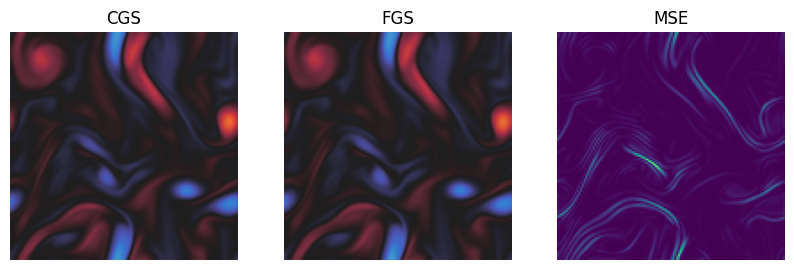

 10%|▉         | 480/5000 [00:01<00:11, 388.33it/s]

action =  -0.32739335 omega1 =  1.98340503627137 omega2 =  1.996477709279388 1.9834050386513569
0.9966523119038518


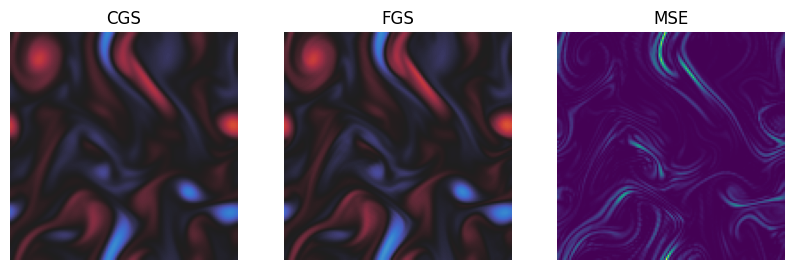

 20%|██        | 1000/5000 [00:03<00:10, 393.40it/s]

action =  -0.2553353 omega1 =  1.9862823214259908 omega2 =  1.996477709279388 1.9862822845361938
0.9914460750740507


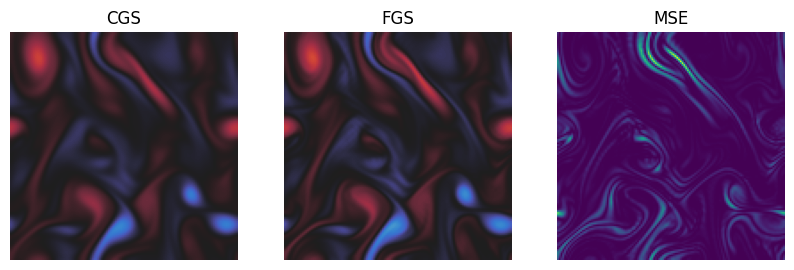

 30%|██▉       | 1480/5000 [00:04<00:08, 391.27it/s]

action =  -0.22761816 omega1 =  1.987389015331362 omega2 =  1.996477709279388 1.987389017711349
0.9855888452382856


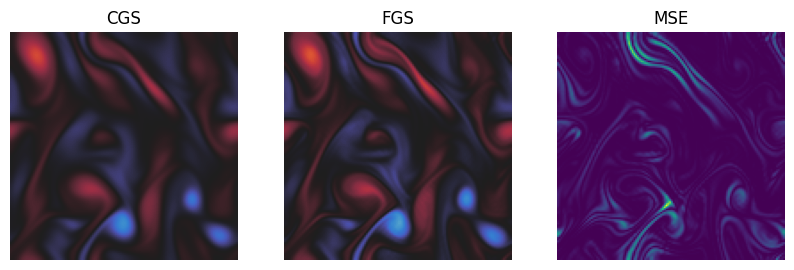

 40%|████      | 2000/5000 [00:05<00:07, 392.98it/s]

action =  -0.20673124 omega1 =  1.9882230817381092 omega2 =  1.996477709279388 1.9882230228334337
0.9799497887181776


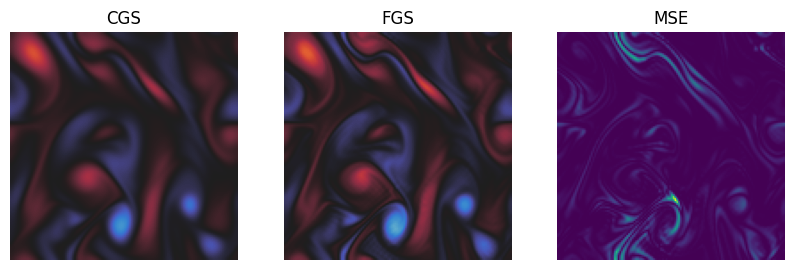

 50%|████▉     | 2480/5000 [00:07<00:06, 391.86it/s]

action =  -0.19448817 omega1 =  1.988711931045987 omega2 =  1.996477709279388 1.9887118834462492
0.9744846429241713


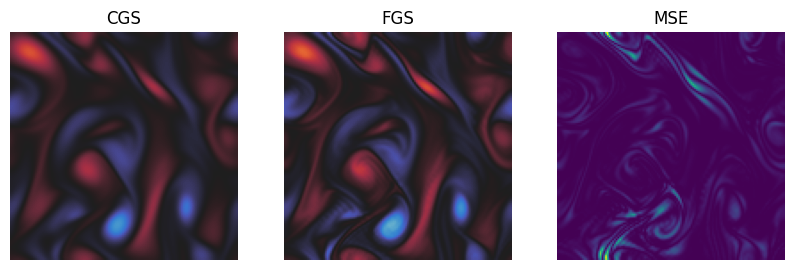

 60%|██████    | 3000/5000 [00:08<00:05, 392.72it/s]

action =  -0.18450725 omega1 =  1.9891104598512654 omega2 =  1.996477709279388 1.9891104170115015
0.9647124458649017


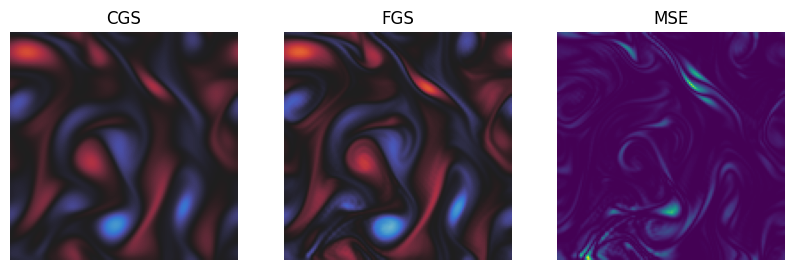

 70%|██████▉   | 3480/5000 [00:10<00:03, 390.49it/s]

action =  -0.16802837 omega1 =  1.9897684072279105 omega2 =  1.996477709279388 1.9897684113928875
0.9490732868257098


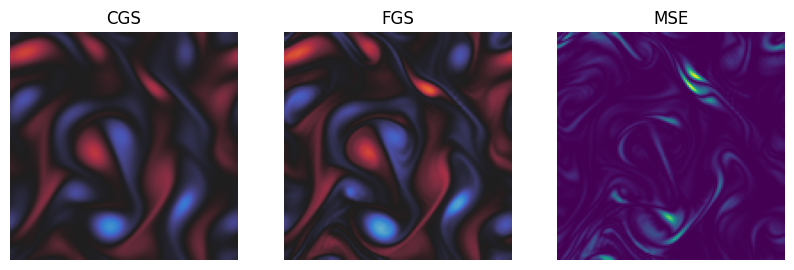

 80%|████████  | 4000/5000 [00:11<00:02, 391.49it/s]

action =  -0.17206766 omega1 =  1.9896071631158914 omega2 =  1.996477709279388 1.9896071244411044
0.9314879446568534


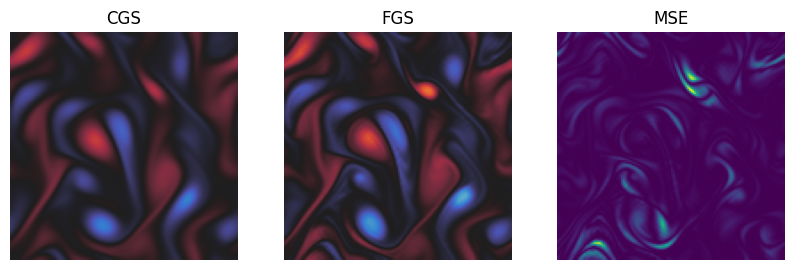

 90%|████████▉ | 4480/5000 [00:12<00:01, 391.10it/s]

action =  -0.19712354 omega1 =  1.98860661662596 omega2 =  1.996477709279388 1.9886066541107534
0.9134170349738874


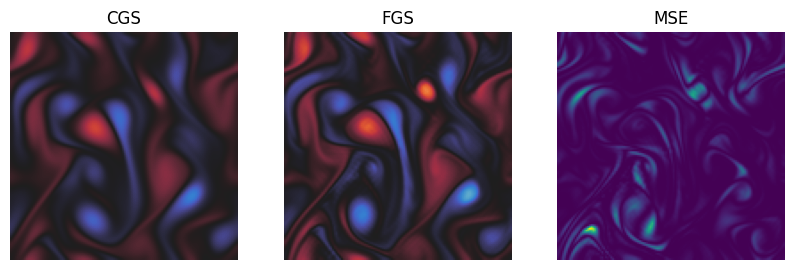

100%|██████████| 5000/5000 [00:14<00:00, 346.11it/s]


In [17]:
obs ,inf = env.reset()
policy.eval()
#print(omg, env.unwrapped.fgs.omega, env.unwrapped.cgs.omega)
for i in tqdm(range(5000)):
    action = policy(Batch(obs=np.array([obs]), info=inf)).act[0]
    
    obs, reward, terminated, truncated, inf = env.step(action.detach().cpu().numpy())
    
    if i%500 == 0:
        #ac = action.detach().cpu().numpy()[0]
        #a = 0.98
        #b = 1.02
        #scaled_ac = a + 0.5*(b-a)*(ac+1)
        #print("action = ",ac, "omega1 = ", env.cgs.omega, "omega2 = ", env.fgs.omega, scaled_ac*env.fgs.omega)
        env.render()
